In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50)

import sqlite3

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, r2_score
from sklearn.utils import resample

from supporting_scripts import utils, data_preproc

# Part 1: Exploratory Data Analysis (EDA)

In [2]:
con = sqlite3.connect("synthetic_claims.db")
cur = con.cursor()
cur.execute('SELECT name FROM sqlite_master WHERE type="table"')
print(cur.fetchall())

[('Demographics',), ('Procedure',), ('Diagnosis',), ('Utilization',), ('Merge',), ('Demographics_Processed',), ('Procedure_Processed',), ('Diagnosis_Processed',)]


## 1.1 Demographics Table

In [3]:
# Import Demographics table as a Pandas dataframe
pd.read_sql_query("SELECT * FROM Demographics LIMIT 5", con)

,Patient Id,Birth Year,Gender,Deceased Date
0,000a708f45d7cea9,1944,female,None
1,000dce3d67c354f1,1952,female,None
2,0019ec94bfe6e6c7,1948,female,None
3,001aa34ee5a87397,1944,male,None
4,0022707b432b96ca,1945,male,None


In [4]:
# Check the data types of each column
pd.read_sql_query("PRAGMA TABLE_INFO(Demographics)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,Patient Id,TEXT,0,None,0
1,1,Birth Year,INTEGER,0,None,0
2,2,Gender,TEXT,0,None,0
3,3,Deceased Date,TIMESTAMP,0,None,0


In [5]:
# Determine the number of unique Patient Ids in the Demographics table
utils.unique_ids('Demographics')


    Demographics Table Duplicate Ids
    -------------------------------
    Unique Patient Ids: 5297
    Total Patient Ids: 5297
    Duplicate Patient Ids: 0
    


Note that there are no duplicate Patient Ids in the Demographics table, as expected

In [6]:
# Determine the range of Birth Year
sql = """
SELECT MIN(`Birth Year`) as Min_Birth_Year, 
       MAX(`Birth Year`) as Max_Birth_Year
FROM Demographics
"""

pd.read_sql_query(sql, con)

,Min_Birth_Year,Max_Birth_Year
0,1919,1998


In [7]:
# Determine the values and value counts for Gender
sql = """
SELECT Gender, 
       COUNT(`Patient Id`) as Count, 
       100 * COUNT(`Patient Id`)/(SELECT COUNT(`Patient Id`) FROM Demographics) as Percentage 
FROM Demographics GROUP BY Gender
"""

pd.read_sql_query(sql, con)

,Gender,Count,Percentage
0,female,2733,51
1,male,2564,48


In [8]:
# Determine the range of Deceased Date
sql = """
SELECT MIN(`Deceased Date`) as Min_Deceased_Date, 
       MAX(`Deceased Date`) as Max_Deceased_Date
FROM Demographics
"""

pd.read_sql_query(sql, con)

,Min_Deceased_Date,Max_Deceased_Date
0,2018-07-07 00:00:00,2022-01-12 00:00:00


## 1.2 Procedure Table

In [9]:
# Import Procedure table as a Pandas dataframe
pd.read_sql_query("SELECT * FROM Procedure LIMIT 5", con)

,Patient Id,Date,Operations on the endocrine system,Miscellaneous diagnostic and therapeutic procedures,Operations on the ear,Operations on the hemic and lymphatic system,Operations on the respiratory system,Operations on the cardiovascular system,Operations on the eye,Operations on the integumentary system,Operations on the urinary system,Operations on the nervous system,Operations on the male genital organs,Operations on the musculoskeletal system,Operations on the digestive system,Obstetrical procedures,Operations on the female genital organs,Operations on the nose_ mouth_ and pharynx
0,000a708f45d7cea9,2018-02-01 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000a708f45d7cea9,2018-03-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a708f45d7cea9,2018-04-01 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000a708f45d7cea9,2018-05-01 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,000a708f45d7cea9,2018-06-01 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Check the data types of each column
pd.read_sql_query("PRAGMA TABLE_INFO(Procedure)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,Patient Id,TEXT,0,None,0
1,1,Date,TIMESTAMP,0,None,0
2,2,Operations on the endocrine system,INTEGER,0,None,0
3,3,Miscellaneous diagnostic and therapeutic proce...,INTEGER,0,None,0
4,4,Operations on the ear,INTEGER,0,None,0
5,5,Operations on the hemic and lymphatic system,INTEGER,0,None,0
6,6,Operations on the respiratory system,INTEGER,0,None,0
7,7,Operations on the cardiovascular system,INTEGER,0,None,0
8,8,Operations on the eye,INTEGER,0,None,0
9,9,Operations on the integumentary system,INTEGER,0,None,0


In [11]:
# Determine the number of unique Patient Ids in the Demographics table
utils.unique_ids('Procedure')


    Procedure Table Duplicate Ids
    -------------------------------
    Unique Patient Ids: 5297
    Total Patient Ids: 123353
    Duplicate Patient Ids: 118056
    


Note that # Unique Patient Ids = # Unique Patient Ids in the Demographics table (all patients are represented)

In [12]:
# Determine the range of Date
utils.date_range('Procedure')


    Procedure Table Date Range
    -------------------------------
    Start Date: 2018-02-01 00:00:00
    End Date: 2020-01-01 00:00:00
    


## 1.3 Diagnosis Table

In [13]:
# Import Diagnosis table as a Pandas dataframe
pd.read_sql_query("SELECT * FROM Diagnosis LIMIT 5", con)

,Patient Id,Date,Diseases of the digestive system,Diseases of the nervous system and sense organs,Diseases of the musculoskeletal system and connective tissue,Endocrine_ nutritional_ and metabolic diseases and immunity disorders,Residual codes_ unclassified_ all E codes,Certain conditions originating in the perinatal period,Congenital anomalies,Neoplasms,Infectious and parasitic diseases,Diseases of the skin and subcutaneous tissue,Diseases of the blood and blood-forming organs,Mental illness,Injury and poisoning,Complications of pregnancy_ childbirth_ and the puerperium,Symptoms_ signs_ and ill-defined conditions and factors influencing health status,Diseases of the respiratory system,Diseases of the circulatory system,Diseases of the genitourinary system
0,000a708f45d7cea9,2018-02-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,000a708f45d7cea9,2018-03-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a708f45d7cea9,2018-04-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,000a708f45d7cea9,2018-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,000a708f45d7cea9,2018-06-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [14]:
# Check the data types of each column
pd.read_sql_query("PRAGMA TABLE_INFO(Diagnosis)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,Patient Id,TEXT,0,None,0
1,1,Date,TIMESTAMP,0,None,0
2,2,Diseases of the digestive system,INTEGER,0,None,0
3,3,Diseases of the nervous system and sense organs,INTEGER,0,None,0
4,4,Diseases of the musculoskeletal system and con...,INTEGER,0,None,0
5,5,Endocrine_ nutritional_ and metabolic diseases...,INTEGER,0,None,0
6,6,Residual codes_ unclassified_ all E codes,INTEGER,0,None,0
7,7,Certain conditions originating in the perinata...,INTEGER,0,None,0
8,8,Congenital anomalies,INTEGER,0,None,0
9,9,Neoplasms,INTEGER,0,None,0


In [15]:
# Determine the number of unique Patient Ids in the Diagnosis table
utils.unique_ids('Diagnosis')


    Diagnosis Table Duplicate Ids
    -------------------------------
    Unique Patient Ids: 5297
    Total Patient Ids: 123353
    Duplicate Patient Ids: 118056
    


Note that # Unique Patient Ids = # Unique Patient Ids in the Demographics table (all patients are represented)

In [16]:
# Determine the range of Date
utils.date_range('Diagnosis')


    Diagnosis Table Date Range
    -------------------------------
    Start Date: 2018-02-01 00:00:00
    End Date: 2020-01-01 00:00:00
    


Note that the start and end dates match those of the Procedure table

## 1.4 Utilization Table

In [17]:
# Import Utilization table as a Pandas dataframe
pd.read_sql_query("SELECT * FROM Utilization LIMIT 5", con)

,Patient Id,Date,Office_Visits,ER_Visits,Admits
0,000a708f45d7cea9,2018-02-01 00:00:00,0,0,0
1,000a708f45d7cea9,2018-03-01 00:00:00,0,0,0
2,000a708f45d7cea9,2018-04-01 00:00:00,0,0,0
3,000a708f45d7cea9,2018-05-01 00:00:00,0,0,0
4,000a708f45d7cea9,2018-06-01 00:00:00,0,0,0


In [18]:
# Check the data types of each column
pd.read_sql_query("PRAGMA TABLE_INFO(Utilization)", con)

,cid,name,type,notnull,dflt_value,pk
0,0,Patient Id,TEXT,0,None,0
1,1,Date,TIMESTAMP,0,None,0
2,2,Office_Visits,INTEGER,0,None,0
3,3,ER_Visits,INTEGER,0,None,0
4,4,Admits,INTEGER,0,None,0


In [19]:
# Determine the number of unique Patient Ids in the Utilization table
utils.unique_ids('Utilization')


    Utilization Table Duplicate Ids
    -------------------------------
    Unique Patient Ids: 5297
    Total Patient Ids: 123353
    Duplicate Patient Ids: 118056
    


In [20]:
# Determine the range of Date
utils.date_range('Utilization')


    Utilization Table Date Range
    -------------------------------
    Start Date: 2018-02-01 00:00:00
    End Date: 2020-01-01 00:00:00
    


# Part 2: Data Cleaning and Processing

## 2.1 Feature Consolidation

### 2.1.1 Demographics Table

For the `Demographics` table, we need to decide how to treat the `Deceased Date` column. We need to make a decision on how to handle deceased date. For the purpose of this model, I think we should exclude patients who died within our `Date` range + 6 months (2018-02-01 to 2020-07-01). Any patients who died after this time frame can remain in the dataset, as their death is not relevant in the timeframe of our model. After this filtering, we can remove the `Deceased Date` column.

In [21]:
# Create a new table with the proper filtering
sql = """
DROP TABLE IF EXISTS Demographics_Processed;

CREATE TABLE Demographics_Processed as
SELECT *
FROM Demographics   
WHERE date(`Deceased Date`) > date('2020-07-01') OR `Deceased Date` IS NULL
"""

cur.executescript(sql)

In [22]:
sql = """
SELECT *
FROM Demographics_Processed
"""

pd.read_sql_query(sql, con)

,Patient Id,Birth Year,Gender,Deceased Date
0,000a708f45d7cea9,1944,female,None
1,000dce3d67c354f1,1952,female,None
2,0019ec94bfe6e6c7,1948,female,None
3,001aa34ee5a87397,1944,male,None
4,0022707b432b96ca,1945,male,None
...,...,...,...,...
5291,ff77a4c5b94e6624,1936,male,2021-01-31 00:00:00
5292,ff8e75042eb186a6,1933,female,None
5293,ff9229d44b2ce8d9,1947,male,None
5294,ffa17f6d2dc9ce49,1946,female,None


### 2.1.2 Procedure Table

We need to analyze the numeric columns in the `Procedure` and `Diagnosis` tables for low variance, as it is likely that these columns contain large amounts of 0's. Let's look at the percent of each numeric column that has a value of 0:

In [23]:
utils.value_counts('Procedure')


        Operations on the endocrine system Value Counts
        -------------------------------
        Percent 0: 99.96%
        

        Miscellaneous diagnostic and therapeutic procedures Value Counts
        -------------------------------
        Percent 0: 63.66%
        

        Operations on the ear Value Counts
        -------------------------------
        Percent 0: 99.90%
        

        Operations on the hemic and lymphatic system Value Counts
        -------------------------------
        Percent 0: 99.94%
        

        Operations on the respiratory system Value Counts
        -------------------------------
        Percent 0: 99.36%
        

        Operations on the cardiovascular system Value Counts
        -------------------------------
        Percent 0: 99.09%
        

        Operations on the eye Value Counts
        -------------------------------
        Percent 0: 98.90%
        

        Operations on the integumentary system Value Counts
       

To combat these low variance features, let's combine some features:

In [24]:
# Create a new table with the combined features. Note we are also dropping any columns with 100% O's
sql = """
DROP TABLE IF EXISTS Procedure_Processed;

CREATE TABLE Procedure_Processed as
SELECT `Patient Id`,
       Date,
       `Operations on the endocrine system` + 
       `Operations on the hemic and lymphatic system` +
       `Operations on the respiratory system` +
       `Operations on the cardiovascular system` +
       `Operations on the urinary system` +
       `Operations on the nervous system` +
       `Operations on the digestive system` AS Internal_Operations,
       `Operations on the ear` +
       `Operations on the nose_ mouth_ and pharynx` +
       `Operations on the eye` +
       `Operations on the male genital organs` +
       `Operations on the female genital organs` AS External_Operations,
       `Miscellaneous diagnostic and therapeutic procedures` AS Misc_Procedures
FROM Procedure   
GROUP BY `Patient Id`, Date;
"""

cur.executescript(sql)

In [25]:
sql = """
SELECT *
FROM Procedure_Processed
"""

pd.read_sql_query(sql, con)

,Patient Id,Date,Internal_Operations,External_Operations,Misc_Procedures
0,000a708f45d7cea9,2018-02-01 00:00:00,0,0,1
1,000a708f45d7cea9,2018-03-01 00:00:00,0,0,0
2,000a708f45d7cea9,2018-04-01 00:00:00,0,0,1
3,000a708f45d7cea9,2018-05-01 00:00:00,0,0,1
4,000a708f45d7cea9,2018-06-01 00:00:00,0,0,1
...,...,...,...,...,...
123348,ffb2b19bb732e580,2019-09-01 00:00:00,0,0,0
123349,ffb2b19bb732e580,2019-10-01 00:00:00,0,0,0
123350,ffb2b19bb732e580,2019-11-01 00:00:00,0,0,1
123351,ffb2b19bb732e580,2019-12-01 00:00:00,0,0,1


In [26]:
utils.value_counts('Procedure_Processed')


        Internal_Operations Value Counts
        -------------------------------
        Percent 0: 95.83%
        

        External_Operations Value Counts
        -------------------------------
        Percent 0: 98.00%
        

        Misc_Procedures Value Counts
        -------------------------------
        Percent 0: 63.66%
        


Our new table has slighlty improved variance, although these features can be further consolidated if necessary.

Let's do the same thing with the `Diagnosis` table:

### 2.1.3 Diagnosis Table

In [27]:
utils.value_counts('Diagnosis')


        Diseases of the digestive system Value Counts
        -------------------------------
        Percent 0: 93.09%
        

        Diseases of the nervous system and sense organs Value Counts
        -------------------------------
        Percent 0: 86.88%
        

        Diseases of the musculoskeletal system and connective tissue Value Counts
        -------------------------------
        Percent 0: 82.17%
        

        Endocrine_ nutritional_ and metabolic diseases and immunity disorders Value Counts
        -------------------------------
        Percent 0: 79.10%
        

        Residual codes_ unclassified_ all E codes Value Counts
        -------------------------------
        Percent 0: 89.87%
        

        Certain conditions originating in the perinatal period Value Counts
        -------------------------------
        Percent 0: 100.00%
        

        Congenital anomalies Value Counts
        -------------------------------
        Percent 0: 97.33%

In [28]:
# Create a new table with the combined features. Note we are also dropping any columns with 100% O's
sql = """
DROP TABLE IF EXISTS Diagnosis_Processed;

CREATE TABLE Diagnosis_Processed as
SELECT `Patient Id`,
       Date,
       `Diseases of the digestive system` + 
       `Diseases of the nervous system and sense organs` +
       `Diseases of the musculoskeletal system and connective tissue` +
       `Diseases of the respiratory system` + 
       `Diseases of the circulatory system` +
       `Diseases of the genitourinary system` +
       `Diseases of the blood and blood-forming organs` +
       `Endocrine_ nutritional_ and metabolic diseases and immunity disorders` AS Internal_System_Diseases,
       `Diseases of the skin and subcutaneous tissue` AS External_Diseases,
       `Congenital anomalies` AS Congenital_Diseases,
       `Neoplasms`,
       `Infectious and parasitic diseases` AS Infectious_And_Parasitic_Diseases,
       `Mental illness` AS Mental_Illness,
       `Injury and poisoning` AS Injury_And_Poisoning,
       `Complications of pregnancy_ childbirth_ and the puerperium` +
       `Residual codes_ unclassified_ all E codes` +
       `Symptoms_ signs_ and ill-defined conditions and factors influencing health status` AS Misc_Diseases
       
FROM Diagnosis   
GROUP BY `Patient Id`, Date;
"""

cur.executescript(sql)

In [29]:
sql = """
SELECT *
FROM Diagnosis_Processed
"""

pd.read_sql_query(sql, con)

,Patient Id,Date,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases
0,000a708f45d7cea9,2018-02-01 00:00:00,1,0,0,0,0,0,1,1
1,000a708f45d7cea9,2018-03-01 00:00:00,0,0,0,0,0,0,0,0
2,000a708f45d7cea9,2018-04-01 00:00:00,1,0,0,0,0,0,0,1
3,000a708f45d7cea9,2018-05-01 00:00:00,1,0,0,0,0,0,0,0
4,000a708f45d7cea9,2018-06-01 00:00:00,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
123348,ffb2b19bb732e580,2019-09-01 00:00:00,0,0,0,0,0,0,0,0
123349,ffb2b19bb732e580,2019-10-01 00:00:00,0,0,0,0,0,0,0,0
123350,ffb2b19bb732e580,2019-11-01 00:00:00,0,0,0,0,1,0,0,0
123351,ffb2b19bb732e580,2019-12-01 00:00:00,4,0,0,0,0,0,0,1


In [30]:
utils.value_counts('Diagnosis_Processed')


        Internal_System_Diseases Value Counts
        -------------------------------
        Percent 0: 59.40%
        

        External_Diseases Value Counts
        -------------------------------
        Percent 0: 95.41%
        

        Congenital_Diseases Value Counts
        -------------------------------
        Percent 0: 97.33%
        

        Neoplasms Value Counts
        -------------------------------
        Percent 0: 93.71%
        

        Infectious_And_Parasitic_Diseases Value Counts
        -------------------------------
        Percent 0: 92.98%
        

        Mental_Illness Value Counts
        -------------------------------
        Percent 0: 93.27%
        

        Injury_And_Poisoning Value Counts
        -------------------------------
        Percent 0: 93.47%
        

        Misc_Diseases Value Counts
        -------------------------------
        Percent 0: 77.68%
        


### 2.1.4 Utilization Table

For the `Utilization` table, I am going to remove the `Admit` column because it could cause overfitting in our model, as inpatient admissions are often caused by ER visits. 

## 2.2 Data Merging

From our EDA, we know that all 5297 unique Patient Ids from the `Demographics` table are represented in the other 3 tables and that the date ranges for the `Procedure`, `Diagnosis`, and `Utilization` tables match. To merge our 4 tables, we can first merge the demographic data with any of the other 3 tables on `Patient Id` alone, and then merge the remaining tables on both `Patient Id` and `Date`.

In [31]:
# Merge Demographics table with Procedure table on Patient Id, then with Diagnosis and Utilization table on Patient Id and Date
sql = """
WITH m1 as (SELECT de.`Patient Id`,
       de.`Birth Year`,
       de.Gender,
       p.Date,
       p.Internal_Operations,
       p.External_Operations,
       p.Misc_Procedures
FROM Demographics_Processed as de
JOIN Procedure_Processed as p
    USING(`Patient Id`)
ORDER BY `Patient Id`, Date)

SELECT m1.*,
       di.Internal_System_Diseases,
       di.External_Diseases,
       di.Congenital_Diseases,
       di.Neoplasms,
       di.Infectious_And_Parasitic_Diseases,
       di.Mental_Illness,
       di.Injury_And_Poisoning,
       di.Misc_Diseases,
       u.Office_Visits,
       u.ER_Visits
FROM m1
JOIN Diagnosis_Processed as di
    USING(`Patient Id`, Date)
JOIN Utilization as u
    USING(`Patient Id`, Date)
ORDER BY `Patient Id`, Date
"""

df = pd.read_sql_query(sql, con)
df

,Patient Id,Birth Year,Gender,Date,Internal_Operations,External_Operations,Misc_Procedures,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits
0,000a708f45d7cea9,1944,female,2018-02-01 00:00:00,0,0,1,1,0,0,0,0,0,1,1,0,0
1,000a708f45d7cea9,1944,female,2018-03-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a708f45d7cea9,1944,female,2018-04-01 00:00:00,0,0,1,1,0,0,0,0,0,0,1,0,0
3,000a708f45d7cea9,1944,female,2018-05-01 00:00:00,0,0,1,1,0,0,0,0,0,0,0,0,0
4,000a708f45d7cea9,1944,female,2018-06-01 00:00:00,0,0,1,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123329,ffb2b19bb732e580,1946,male,2019-09-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0
123330,ffb2b19bb732e580,1946,male,2019-10-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0
123331,ffb2b19bb732e580,1946,male,2019-11-01 00:00:00,0,0,1,0,0,0,0,1,0,0,0,0,0
123332,ffb2b19bb732e580,1946,male,2019-12-01 00:00:00,0,0,1,4,0,0,0,0,0,0,1,0,0


To predict whether a patient will have one or more emergency room visits in the following 6 months, let's create 4 6-month periods from the dataset. We can then create a new sum variable of the number of ER visits in the 6 months following the first date in each period. Merging these dataframes back together, we are left with 4 data points for each patient, each data point is the first date of each period, contains information on the patient from the previous month, and has a count of their ER visits in the next 6 months.

In [32]:
period1_df = df[(df['Date'] > '2018-02-01') & (df['Date'] < '2018-08-01')]
period2_df = df[(df['Date'] > '2018-08-01') & (df['Date'] < '2019-02-01')]
period3_df = df[(df['Date'] > '2019-02-01') & (df['Date'] < '2019-08-01')]
period4_df = df[(df['Date'] > '2019-08-01') & (df['Date'] < '2020-02-01')]

In [33]:
p1_ER_df = period1_df.groupby('Patient Id')['ER_Visits'].sum().to_frame().reset_index()
p1_ER_df['Date'] = '2018-02-01 00:00:00'
p2_ER_df = period2_df.groupby('Patient Id')['ER_Visits'].sum().to_frame().reset_index()
p2_ER_df['Date'] = '2018-08-01 00:00:00'
p3_ER_df = period3_df.groupby('Patient Id')['ER_Visits'].sum().to_frame().reset_index()
p3_ER_df['Date'] = '2019-02-01 00:00:00'
p4_ER_df = period4_df.groupby('Patient Id')['ER_Visits'].sum().to_frame().reset_index()
p4_ER_df['Date'] = '2019-08-01 00:00:00'
all_periods_df = pd.concat([p1_ER_df, p2_ER_df, p3_ER_df, p4_ER_df])

Now that we have removed the dependence of our data on Patient Id and Date, we can remove those columns.

In [34]:
df = df.drop(columns=['ER_Visits'], errors='ignore')
df_final = df.merge(all_periods_df, how='inner', on=['Patient Id', 'Date'])
df_final = df_final.drop(columns=['Patient Id', 'Date'], errors='ignore')
df_final

,Birth Year,Gender,Internal_Operations,External_Operations,Misc_Procedures,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits
0,1944,female,0,0,1,1,0,0,0,0,0,1,1,0,0
1,1944,female,0,0,1,1,0,0,0,0,0,0,1,0,0
2,1944,female,0,0,1,1,0,0,0,0,0,0,1,0,0
3,1944,female,0,0,1,1,0,0,0,0,0,0,1,0,0
4,1952,female,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20345,1946,female,0,0,0,0,0,0,0,0,0,0,0,0,0
20346,1946,male,0,0,1,3,0,0,1,0,0,0,1,0,0
20347,1946,male,0,0,0,0,0,0,0,0,0,0,0,0,0
20348,1946,male,0,0,0,0,0,0,0,0,0,0,0,0,0


Finally, we need to create dummy variables for the `Gender` column:

In [35]:
df_final = pd.get_dummies(df_final)
df_final.head()

,Birth Year,Internal_Operations,External_Operations,Misc_Procedures,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits,Gender_female,Gender_male
0,1944,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0
1,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
3,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
4,1952,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 2.3 Data Validation

Now that we have our final merged dataframe, lets do a few checks on the data:

In [36]:
# Check for null values
data_preproc.check_nulls(df_final)

,# Nulls
Birth Year,0
Internal_Operations,0
External_Operations,0
Misc_Procedures,0
Internal_System_Diseases,0
External_Diseases,0
Congenital_Diseases,0
Neoplasms,0
Infectious_And_Parasitic_Diseases,0
Mental_Illness,0


In [37]:
# Check for high correlation (Spearmann coeff > 0.7) of features that could lead to overfitting
data_preproc.check_corr(df_final, threshold=0.7)

,Birth Year,Internal_Operations,External_Operations,Misc_Procedures,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits,Gender_female,Gender_male
Birth Year,1.000000,0.003961,-0.056732,-0.077563,-0.106735,-0.029112,-0.032537,-0.051788,-0.047965,0.011002,-0.057280,-0.056276,-0.076357,-0.042968,-0.078518,0.078518
Internal_Operations,0.003961,1.000000,0.046880,0.315050,0.410868,0.078976,0.096032,0.162220,0.146636,0.147067,0.198815,0.358829,0.177814,0.152101,-0.001168,0.001168
External_Operations,-0.056732,0.046880,1.000000,0.120825,0.118692,0.025072,0.037568,0.076436,0.032374,0.018011,0.025844,0.126897,0.087054,0.040411,0.019242,-0.019242
Misc_Procedures,-0.077563,0.315050,0.120825,1.000000,0.775791,0.182265,0.177911,0.369094,0.258836,0.366684,0.433104,0.602215,0.513613,0.269054,0.056075,-0.056075
Internal_System_Diseases,-0.106735,0.410868,0.118692,0.775791,1.000000,0.215007,0.255280,0.176603,0.332867,0.389279,0.455721,0.683365,0.475078,0.327943,0.035814,-0.035814
External_Diseases,-0.029112,0.078976,0.025072,0.182265,0.215007,1.000000,0.059860,0.102066,0.228879,0.095368,0.150166,0.180503,0.145213,0.092729,0.005662,-0.005662
Congenital_Diseases,-0.032537,0.096032,0.037568,0.177911,0.255280,0.059860,1.000000,0.057357,0.089688,0.093164,0.105734,0.185668,0.177805,0.054773,-0.003397,0.003397
Neoplasms,-0.051788,0.162220,0.076436,0.369094,0.176603,0.102066,0.057357,1.000000,0.080906,0.059006,0.062919,0.206505,0.175949,0.051764,-0.012619,0.012619
Infectious_And_Parasitic_Diseases,-0.047965,0.146636,0.032374,0.258836,0.332867,0.228879,0.089688,0.080906,1.000000,0.160632,0.125411,0.254828,0.115203,0.131090,0.011214,-0.011214
Mental_Illness,0.011002,0.147067,0.018011,0.366684,0.389279,0.095368,0.093164,0.059006,0.160632,1.000000,0.190152,0.308843,0.186810,0.241570,0.032972,-0.032972


We note that `Internal_System_Diseases` is highly correlated with `Misc_Procedures`, but since the correlation is still well below 100% I feel ok to keep both features. 

In [38]:
# Check for columns with low variance (< 0.05)
data_preproc.check_var(df_final, threshold=0.05)

,Variance
Birth Year,97.427091
Internal_Operations,0.085560
External_Operations,0.022168
Misc_Procedures,2.302523
Internal_System_Diseases,13.914314
External_Diseases,0.124726
Congenital_Diseases,0.035475
Neoplasms,0.339074
Infectious_And_Parasitic_Diseases,0.107813
Mental_Illness,0.242026


Let's combine `Internal_Operations` and `External_Operations` and group `Congenital_Diseases` with `Misc_Diseases`

In [39]:
df_final['Operations'] = df_final['Internal_Operations'] + df_final['External_Operations']
df_final['Misc_Diseases'] = df_final['Misc_Diseases'] + df_final['Congenital_Diseases']
df_final.head()

,Birth Year,Internal_Operations,External_Operations,Misc_Procedures,Internal_System_Diseases,External_Diseases,Congenital_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits,Gender_female,Gender_male,Operations
0,1944,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0
1,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
2,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
3,1944,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0
4,1952,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
df_final = df_final.drop(columns=['Internal_Operations', 'External_Operations', 'Congenital_Diseases'], errors='ignore')
df_final.head()

,Birth Year,Misc_Procedures,Internal_System_Diseases,External_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,ER_Visits,Gender_female,Gender_male,Operations
0,1944,1,1,0,0,0,0,1,1,0,0,1,0,0
1,1944,1,1,0,0,0,0,0,1,0,0,1,0,0
2,1944,1,1,0,0,0,0,0,1,0,0,1,0,0
3,1944,1,1,0,0,0,0,0,1,0,0,1,0,0
4,1952,0,0,0,0,0,0,0,0,0,0,1,0,0


In [41]:
# Check for columns with low variance (< 0.05)
data_preproc.check_var(df_final, threshold=0.05)

,Variance
Birth Year,97.427091
Misc_Procedures,2.302523
Internal_System_Diseases,13.914314
External_Diseases,0.124726
Neoplasms,0.339074
Infectious_And_Parasitic_Diseases,0.107813
Mental_Illness,0.242026
Injury_And_Poisoning,0.353437
Misc_Diseases,1.220961
Office_Visits,0.322704


Finally, let's convert our output variable, `ER_Visits`, to a binary variable where 0 visits = 0 and 1 or more visits = 1.

In [42]:
df_final['6mo_ER_Visits_Binary'] = df_final.apply(data_preproc.binarize_visits, axis=1)
df_final = df_final.drop(columns=['ER_Visits'], errors='ignore')
df_final.head()

,Birth Year,Misc_Procedures,Internal_System_Diseases,External_Diseases,Neoplasms,Infectious_And_Parasitic_Diseases,Mental_Illness,Injury_And_Poisoning,Misc_Diseases,Office_Visits,Gender_female,Gender_male,Operations,6mo_ER_Visits_Binary
0,1944,1,1,0,0,0,0,1,1,0,1,0,0,0
1,1944,1,1,0,0,0,0,0,1,0,1,0,0,0
2,1944,1,1,0,0,0,0,0,1,0,1,0,0,0
3,1944,1,1,0,0,0,0,0,1,0,1,0,0,0
4,1952,0,0,0,0,0,0,0,0,0,1,0,0,0


In [43]:
df_final['6mo_ER_Visits_Binary'].value_counts()

0    17604
1     2746
Name: 6mo_ER_Visits_Binary, dtype: int64

# Part 3: Model Building

## Split into test, train, and validation sets

In [44]:
X = df_final.drop('6mo_ER_Visits_Binary', axis=1).values
y = df_final['6mo_ER_Visits_Binary'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16280, 13) (16280,)
(4070, 13) (4070,)


## Train the model

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluate the model on the test set

RMSE: 0.361
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      3508
           1       0.68      0.11      0.19       562

    accuracy                           0.87      4070
   macro avg       0.78      0.55      0.56      4070
weighted avg       0.85      0.87      0.83      4070



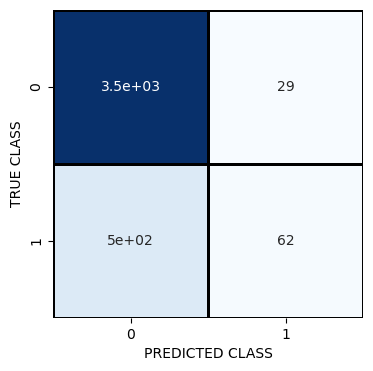

In [47]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.3f}")
print(classification_report(y_test, y_pred))

cfm = confusion_matrix(y_test, y_pred)
df_cfm = pd.DataFrame(cfm)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax = sns.heatmap(df_cfm, cmap='Blues', annot=True, linewidths=1, linecolor='black', cbar=False)
ax.set_xlabel('PREDICTED CLASS', color='black')
ax.set_ylabel('TRUE CLASS', color='black')
plt.show()

## Perform cross validation

In [48]:
cv_pred = cross_val_predict(model, X, y, cv=3)
cv_scores = cross_val_score(model, X, y, cv=3)
print('Cross-validated scores:', cv_scores)
cv_accuracy = r2_score(y, cv_pred)
print('Cross-Predicted Accuracy:', cv_accuracy)

Cross-validated scores: [0.86954599 0.87159074 0.86805248]
Cross-Predicted Accuracy: -0.11599499915019629


### Baseline model analysis
- We have a high F1-score for our negative class but very low F1-score for our positive class
- The main issue with the current model is a large class imbalance. We can attempt to solve this by 
    1. Undersampling the majority class (0)
    2. Using a tree-based model that is less affected by class imbalance
    3. Using a boosting method

In [49]:
X_undersampled, y_undersampled = resample(X[y == 0], y[y == 0], replace=True, n_samples=X[y == 1].shape[0], random_state=42)

In [50]:
X_balanced = np.vstack((X[y == 1], X_undersampled))
y_balanced = np.hstack((y[y == 1], y_undersampled))

In [51]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train_b.shape, y_train_b.shape)
print(X_test_b.shape, y_test_b.shape)

(4393, 13) (4393,)
(1099, 13) (1099,)


In [52]:
model_b = GBC(random_state=42)
model_b.fit(X_train_b, y_train_b)
y_pred_b = model_b.predict(X_test_b)

RMSE: 0.587
              precision    recall  f1-score   support

           0       0.64      0.69      0.66       545
           1       0.67      0.62      0.65       554

    accuracy                           0.66      1099
   macro avg       0.66      0.66      0.65      1099
weighted avg       0.66      0.66      0.65      1099



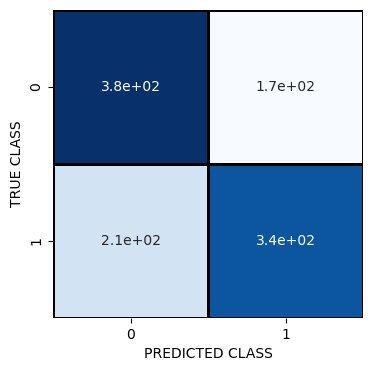

In [53]:
rmse_b = mean_squared_error(y_test_b, y_pred_b, squared=False)
print(f"RMSE: {rmse_b:.3f}")
print(classification_report(y_test_b, y_pred_b))

cfm_b = confusion_matrix(y_test_b, y_pred_b)
df_cfm_b = pd.DataFrame(cfm_b)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax = sns.heatmap(df_cfm_b, cmap='Blues', annot=True, linewidths=1, linecolor='black', cbar=False)
ax.set_xlabel('PREDICTED CLASS', color='black')
ax.set_ylabel('TRUE CLASS', color='black')
plt.show()

In [54]:
cv_pred_b = cross_val_predict(model_b, X_balanced, y_balanced, cv=3)
cv_scores_b = cross_val_score(model_b, X_balanced, y_balanced, cv=3)
print('Cross-validated scores:', cv_scores_b)
cv_accuracy_b = r2_score(y_balanced, cv_pred_b)
print('Cross-Predicted Accuracy:', cv_accuracy_b)

Cross-validated scores: [0.67558711 0.66903332 0.67377049]
Cross-Predicted Accuracy: -0.3088128186453023


### Balanced model analysis
- We have improved the F1-score of the positive class (and in turn decreased the F1-score of the negative class)
- The model could be improved with additional feature engineering, hyperparameter tuning, and possibly the selection of another type of model